# Finding Cu crystal ground state via the Augmented Plane method

This project is adapted from Thijssen and uses data taken from Energy Band Structure of Copper by Glenn A. Burdick.

## Theory

APW is a method for solving the single particle Schrodinger equation in a crystal. It uses the variational principle in the plane wave basis (this is viable due to Bloch's theorem). A basis element for an eigenstate labelled $\vec{k}$ is:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Due to the size of the potential near the nuclei, the basis set required is too large. APW solves this problem with the Muffin approximation. The equation near the nuclei ($r<R$) is solved exactly and related to the plane waves via boundary conditions at $R$. This allows for the variational method to be applied efficiently. For a full description of the theory see Thijssen. 

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation, a brute force approach has been followed. For a given $\vec{k}$, a list of energies (mesh) over a certain range is defined; the determinant associated with each of these energies is then found. The energy for $\vec{k}$ then corresponds to the energy where the determinant changes sign. This approach is not particularly accurate for the size of the mesh considered but it gives the rough band structure.

This notebook attempts to apply this method to Cu. The data used for the potential near the nuclei is taken from the paper specified above. The implementation is roughly correct though there may be some errors (it is hard to tell as the root finding method used here isn't very accurate).



In [96]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
from scipy.linalg import eigh


In [97]:
#constants
a = 6.83087
vol = 3*(a**3)/4

#simulation parameters
l_max = 5
nLim = 2

#recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [182]:
#data for potential
h = 0.005
rsAll = np.arange(0,2.8,step=h)


r_max = rsAll[-2]

def V(r):
    #need to cite where I have taken this from
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return term1 + term2



In [99]:
#generate A
A = np.empty([len(Ks),len(Ks)])
for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1 - 4*np.pi*(r_max**3)/(3*vol)
        else:
            A[i,j] = -4*np.pi*(r_max**2)*sp.spherical_jn(1,kDiff*r_max)/(vol*kDiff)

In [186]:
#code for solution to the muffin part

def getAllUs(l,E):
    """
    Finds R u and u'.
    """
    def g(r):
        """
        Finds f function for Numerov algorithm.
        """
        if r == 0:
            return 0
        return -(l*(l+1)/r**2 + 2*(V(r) - E))
    
    us = [rsAll[0]**(l+1),rsAll[1]**(l+1)]
    for i in range(2,len(rsAll)):
        us.append((2*us[-1]*(1 - 5*(h**2)*g(rsAll[i-1])/12) - us[-2]*(1 + (h**2)*g(rsAll[i-2])/12))/(1 + (h**2)*g(rsAll[i])/12))
    return np.array(us)
    


def getRatio(l,E):
    """
    Finds ratio required for the matrix calculation.
    """

    us = getAllUs(l,E)
    usR = us[-2]
    uDashR = (us[-1] - us[-3])/(2*h)
    return uDashR/usR - 1/r_max 


In [101]:
def findDet(k,E):
    """
    Finds variational problem determinant.
    """

    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),l_max])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                if qi == 0 or qj == 0:
                    C[i,j,l] = 0
                else: 
                    C[i,j,l] = (2*l + 1)*2*np.pi*(r_max**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*r_max)*sp.spherical_jn(l,qj*r_max)/vol
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #returns +1 if the determinant is positive and -1 if the determinant is negative
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks)))
    sign = detData[0]
    return sign


In [102]:
def findZero(lst,k):
    """
    Given a list, finds the list elements that change sign and a list the k arrays of the same length.
    """
    ks = []
    zeroIndexs = []
    for i in range(1,len(lst)):
        if lst[i-1]*lst[i] == -1:
            ks.append(k)
            zeroIndexs.append(int(i))
    return ks,zeroIndexs

In [103]:
#finds the energies for a list of k's
ks = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
EMesh  = np.arange(-.1,.4,step=.02)
kLst = []
indexs = []

for i,k in enumerate(ks):
    detList = [findDet(k,E) for E in EMesh]
    tk,tI =  findZero(detList,k)
    kLst += tk
    indexs += tI

Es = list(map(lambda i: EMesh[i], indexs))

KeyboardInterrupt: 

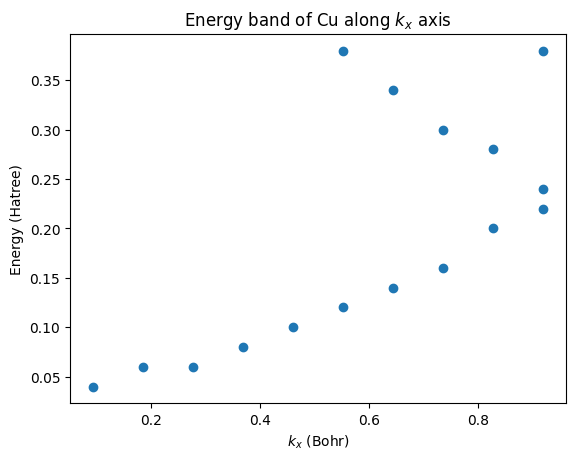

In [ ]:
#Graphs 
kx = list(map(lambda k: k[0],kLst))
plt.scatter(kx,Es)
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()

## LAPW approach

In [187]:
def simpsons(fs):
    sum1 = fs[0] + fs[-1]
    fsNoEnds = fs[1:-1]
    sum2 = 4*np.sum(fsNoEnds[::2])
    sum3 = 2*np.sum(fsNoEnds[1::2])
    return h*(sum1 + sum2 + sum3)/3

In [188]:
def getRDotParams(l,E,usR):
    def g(r):
        if r == 0:
            return 0
        return -(l*(l+1)/r**2 + 2*(V(r) - E)) #sign?
    
    def s(r):
        index = list(rsAll).index(r)
        return -2*usR[index]


    us = list(usR[:2])
    for i in range(2,len(rsAll)):
        us.append((2*us[-1]*(1 - 5*(h**2)*g(rsAll[i-1])/12) - us[-2]*(1 + (h**2)*g(rsAll[i-2])/12) + (h**2)*(s(rsAll[i-2]) + 10*s(rsAll[i-1]) + s(rsAll[i]))/12)/(1 + (h**2)*g(rsAll[i])/12))

    us = np.array(us)

    N =  simpsons(us**2)



    RDot_max = us[-2]/r_max
    RDotDash_max = (us[-1] - us[-3])/(2*h*r_max) - us[-2]/(r_max**2)
    print(simpsons(usR*us)) #the issue is in this not being 0 (increases with l)

    return RDot_max,RDotDash_max,N



In [193]:


def getE(k,E_p,EIndex): # 
    #run simulations
    us = np.empty(len(rsAll))
    RMax = np.empty(l_max)
    RDashMax = np.empty(l_max)
    RDotMax = np.empty(l_max)
    RDotDashMax = np.empty(l_max)
    N = np.empty(l_max)

    for l in range(l_max):
        us = getAllUs(l,E_p)
        #normalisation
        us /= np.sqrt(simpsons(us**2)) #neater way?
        RMax[l] = us[-2]/r_max
        RDashMax[l] = (us[-1] - us[-3])/(2*h*r_max) - us[-2]/(r_max**2)
        RDotMax[l], RDotDashMax[l], N[l] = getRDotParams(l,E_p,us)

        #neater way?
        normConstant = (r_max**2)*(RDashMax[l]*RDotMax[l] - RMax[l]*RDotDashMax[l])
        N[l] /= normConstant**2
        RDotMax[l] /= normConstant
        RDotDashMax[l] /= normConstant

    #define functions required to calcuate matricies
    def a(l,q):
        qMag = np.linalg.norm(q)
        return sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RDotMax[l] - sp.spherical_jn(l,r_max*qMag)*RDotDashMax[l]
        
    def b(l,q):
        qMag = np.linalg.norm(q) 
        return sp.spherical_jn(l,r_max*qMag)*RDashMax[l] - sp.spherical_jn(l,r_max*qMag,derivative=True)*qMag*RMax[l]

    def U(K):
        KMag = np.linalg.norm(K)
        if KMag == 0:
            return 1 - 4*np.pi*(r_max**3)/(3*vol)
        return -4*np.pi*(r_max**2)*sp.spherical_jn(1,KMag*r_max)/(KMag*vol)

    def s(q1,q2,l):
        return a(l,q1)*a(l,q2) + b(l,q1)*b(l,q2)*N[l]
    
    def gamma(q1,q2,l):
        q1Mag = np.linalg.norm(q1)
        q2Mag = np.linalg.norm(q2)

        term1 = RDashMax[l]*RDotMax[l]*(sp.spherical_jn(l,r_max*q1Mag,derivative=True)*q1Mag*sp.spherical_jn(l,r_max*q2Mag) + sp.spherical_jn(l,r_max*q2Mag,derivative=True)*q2Mag*sp.spherical_jn(l,r_max*q1Mag))
        term2 = RDashMax[l]*RDotDashMax[l]*sp.spherical_jn(l,r_max*q1Mag)*sp.spherical_jn(l,r_max*q2Mag)
        term3 = RMax[l]*RDotMax[l]*q1Mag*q2Mag*sp.spherical_jn(l,r_max*q1Mag,derivative=True)*sp.spherical_jn(l,r_max*q2Mag,derivative=True)

        return term1 - term2 - term3


    #calculate matricies
    qs = [k + K for K in Ks]

    #find overlap matrix
    S = np.empty([len(Ks),len(Ks)])

    for i,q_i in enumerate(qs):
        for j,q_j  in enumerate(qs):
            cosThetaij = np.dot(q_i,q_j)/(np.linalg.norm(q_i)*np.linalg.norm(q_j))
            S[i,j] = U(q_i - q_j)
            for l in range(l_max):
                S[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,cosThetaij)*s(q_i,q_j,l)/vol
    
    #find Hamiltonian
    H = np.empty([len(Ks),len(Ks)])

    for i,q_i in enumerate(qs):
        for j,q_j  in enumerate(qs):
            H[i,j] = np.dot(q_i,q_j)*U(q_i - q_j)
            for l in range(l_max):
                H[i,j] += 4*np.pi*(r_max**4)*(2*l + 1)*sp.eval_legendre(l,E_p*s(q_i,q_j,l) + gamma(q_i,q_j,l))/vol

    eigenVal,eigenVec = eigh(H,S,driver="gv") 
    return eigenVal[EIndex]

print(getE(2*np.pi*np.array([1/10,0,0])/a,0.05,0))
print(getE(2*np.pi*np.array([1/10,0,0])/a,0.05,1))
#83.17660683089203


[0.00000000e+00 5.96728961e-05 1.19429189e-04 1.79348848e-04
 2.39508781e-04 2.99983271e-04 3.60844307e-04 4.22161828e-04
 4.84003941e-04 5.46437105e-04 6.09526292e-04 6.73335130e-04
 7.37926031e-04 8.03360313e-04 8.69698299e-04 9.36999421e-04
 1.00532230e-03 1.07472484e-03 1.14526430e-03 1.21699735e-03
 1.28998014e-03 1.36426840e-03 1.43991743e-03 1.51698220e-03
 1.59551737e-03 1.67557736e-03 1.75721637e-03 1.84048843e-03
 1.92544745e-03 2.01214722e-03 2.10064146e-03 2.19098386e-03
 2.28322810e-03 2.37742788e-03 2.47363692e-03 2.57190902e-03
 2.67229805e-03 2.77485799e-03 2.87964295e-03 2.98670716e-03
 3.09610503e-03 3.20789111e-03 3.32212017e-03 3.43884715e-03
 3.55812722e-03 3.68001575e-03 3.80456836e-03 3.93184090e-03
 4.06188949e-03 4.19477049e-03 4.33054054e-03 4.46925653e-03
 4.61097565e-03 4.75575538e-03 4.90365349e-03 5.05472803e-03
 5.20903735e-03 5.36664013e-03 5.52759533e-03 5.69196224e-03
 5.85980044e-03 6.03116985e-03 6.20613068e-03 6.38474347e-03
 6.56706909e-03 6.753168

In [163]:
#finds the energies for a list of k's
ks2 = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
Es2 = [0]

for i,k in enumerate(ks2):
    print(Es2[i])
    Es2.append(getE(k,0.1,0))
Es2 = Es2[1:]


0
0.05154921451827482
0.14795139842022248
0.25742495459585363
0.3551257339746553
0.43589143738464353
-0.8783913838640827
0.05154921451827482
0.14795139842022248
0.25742495459585363
0.3551257339746553
0.43589143738464353
-0.8029614306658119
0.05154921451827482
0.14795139842022248
0.25742495459585363
0.3551257339746553
0.43589143738464353
-0.6806875770014295
0.05154921451827482
0.14795139842022248
0.25742495459585363
0.3551257339746553
0.43589143738464353
-0.5212739633532124
0.05154921451827482
0.14795139842022248


KeyboardInterrupt: 

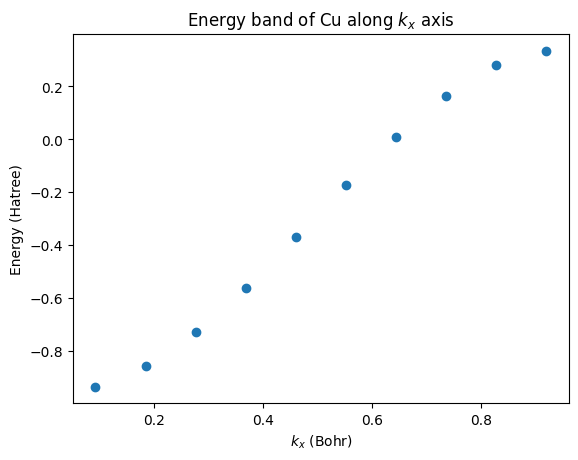

In [147]:
#Graphs 
kx = list(map(lambda k: k[0],ks2))

plt.scatter(kx,Es2)
plt.title(r"Energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()